# Graph Neural Network for Human vs LLM Code Classification

This notebook implements a GIN (Graph Isomorphism Network) to distinguish between human-written and LLM-generated Python code using Abstract Syntax Tree (AST) representations.

## 1. Setup and Imports

In [25]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve


In [26]:
# Import custom modules
from graphdataset import CodeGraphDataset
from process import PythonCodeProcessor

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Data Loading and Exploration

In [29]:
# Configuration
DATA_DIR = 'dataset/python'
VALID_FILE = os.path.join(DATA_DIR, 'valid_no_comment.jsonl')
TEST_FILE = os.path.join(DATA_DIR, 'test_no_comment.jsonl')

MAX_NODES = 500  # Maximum nodes in AST
EMBEDDING_SIZE = 128  # Dimension of node embeddings
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
HIDDEN_DIM = 256
NUM_LAYERS = 5

# NEW: Optimization parameters
MAX_SAMPLES_TRAIN = 5003  # Limit training samples (None = all)
MAX_SAMPLES_TEST = 1001   # Limit test samples (None = all)
TIMEOUT_MINUTES = 200      # Stop processing after 10 minutes

print("Configuration:")
print(f"  Max nodes: {MAX_NODES}")
print(f"  Embedding size: {EMBEDDING_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Hidden dim: {HIDDEN_DIM}")
print(f"  GIN layers: {NUM_LAYERS}")
print(f"  Max training samples: {MAX_SAMPLES_TRAIN}")
print(f"  Max test samples: {MAX_SAMPLES_TEST}")
print(f"  Timeout: {TIMEOUT_MINUTES} minutes")



Configuration:
  Max nodes: 500
  Embedding size: 128
  Batch size: 64
  Learning rate: 0.001
  Epochs: 30
  Hidden dim: 256
  GIN layers: 5
  Max training samples: 5003
  Max test samples: 1001
  Timeout: 200 minutes


In [30]:
# Load datasets with limits and timeout
print("\n" + "="*70)
print("Loading validation dataset...")
print("="*70)
valid_dataset = CodeGraphDataset(
    jsonl_path=VALID_FILE,
    max_nodes=MAX_NODES,
    embedding_size=EMBEDDING_SIZE,
    force_reprocess=True,
    max_samples=MAX_SAMPLES_TRAIN,  # LIMIT SAMPLES
    timeout_minutes=TIMEOUT_MINUTES  # TIMEOUT
)

print("\n" + "="*70)
print("Loading test dataset (sharing vocabulary)...")
print("="*70)
test_dataset = CodeGraphDataset(
    jsonl_path=TEST_FILE,
    processor=valid_dataset.processor,  # Share vocabulary
    max_nodes=MAX_NODES,
    max_samples=MAX_SAMPLES_TEST,  # LIMIT SAMPLES
    timeout_minutes=TIMEOUT_MINUTES  # TIMEOUT
)

print(f"\n{'='*70}")
print(f"Validation set size: {len(valid_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"{'='*70}")


Loading validation dataset...
Processing graphs from dataset/python/valid_no_comment.jsonl
  Limiting to 5003 samples
  Timeout: 200 minutes
Loaded 5003 examples from dataset/python/valid_no_comment.jsonl
Extracting AST node sequences from corpus...


Extracting tokens:   0%|          | 0/51 [00:00<?, ?batch/s]

Conversion failed for snippet: bad input: type=1, value='print', context=('', (8, 12))
Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 11)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 11)


Extracting tokens:   2%|▏         | 1/51 [00:34<28:27, 34.16s/batch]

Conversion failed for snippet: bad token: type=58, value=' ', context=('', (2, 14))
Syntax error in code: EOL while scanning string literal (<unknown>, line 2)
Conversion failed for snippet: bad input: type=22, value='=', context=('', (7, 19))
Conversion failed for snippet: bad input: type=1, value='elif', context=('    ', (3, 4))
Syntax error in code: expected an indented block (<unknown>, line 3)


Extracting tokens:   4%|▍         | 2/51 [01:07<27:40, 33.89s/batch]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (5, 34))
Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 7)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 7)


Extracting tokens:   6%|▌         | 3/51 [01:41<27:03, 33.81s/batch]

Syntax error in code: keyword argument repeated (<unknown>, line 6)
Conversion failed for snippet: bad input: type=22, value='=', context=('', (4, 46))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (15, 37))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (28, 32))
Conversion failed for snippet: bad input: type=20, value='<', context=(' ', (5, 29))
Syntax error in code: invalid syntax (<unknown>, line 5)


Extracting tokens:   8%|▊         | 4/51 [02:16<26:56, 34.40s/batch]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (14, 41))


Extracting tokens:  10%|▉         | 5/51 [02:50<26:12, 34.18s/batch]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 11)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 11)
Conversion failed for snippet: bad input: type=1, value='pass', context=(' ', (51, 64))
Syntax error in code: invalid syntax (<unknown>, line 51)


Extracting tokens:  12%|█▏        | 6/51 [03:22<25:04, 33.43s/batch]

Conversion failed for snippet: bad token: type=58, value=' ', context=('', (9, 12))
Syntax error in code: EOL while scanning string literal (<unknown>, line 9)


Extracting tokens:  16%|█▌        | 8/51 [04:34<25:00, 34.89s/batch]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (14, 112))


Extracting tokens:  18%|█▊        | 9/51 [05:07<24:01, 34.32s/batch]

Conversion failed for snippet: bad input: type=1, value='elif', context=('    ', (3, 4))
Syntax error in code: expected an indented block (<unknown>, line 3)
Conversion failed for snippet: bad input: type=1, value='return', context=('    ', (5, 4))
Syntax error in code: expected an indented block (<unknown>, line 5)
Conversion failed for snippet: bad input: type=5, value='        ', context=('', (3, 0))
Syntax error in code: unexpected indent (<unknown>, line 3)


Extracting tokens:  20%|█▉        | 10/51 [05:43<23:44, 34.74s/batch]

Conversion failed for snippet: bad input: type=1, value='print', context=(' ', (6, 27))
Conversion failed for snippet: bad input: type=1, value='elif', context=('    ', (3, 4))
Syntax error in code: expected an indented block (<unknown>, line 3)


Extracting tokens:  22%|██▏       | 11/51 [06:21<23:47, 35.69s/batch]

Conversion failed for snippet: ('EOF in multi-line statement', (4, 0))
Syntax error in code: unexpected EOF while parsing (<unknown>, line 3)
Conversion failed for snippet: bad input: type=22, value='=', context=('', (15, 55))


Extracting tokens:  24%|██▎       | 12/51 [06:58<23:24, 36.00s/batch]

Conversion failed for snippet: bad input: type=1, value='word', context=('  \n            ', (4, 12))
Syntax error in code: invalid syntax (<unknown>, line 4)
Conversion failed for snippet: bad input: type=3, value="'f_bfree'", context=('  \n            ', (12, 12))
Syntax error in code: invalid syntax (<unknown>, line 12)


Extracting tokens:  25%|██▌       | 13/51 [07:32<22:28, 35.48s/batch]

Conversion failed for snippet: bad input: type=1, value='headers', context=('  \n        ', (9, 8))
Syntax error in code: invalid syntax (<unknown>, line 9)
Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 4)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 4)
Syntax error in code: (unicode error) 'unicodeescape' codec can't decode bytes in position 0-1: malformed \N character escape (<unknown>, line 6)
Conversion failed for snippet: bad input: type=22, value='=', context=('', (42, 54))
Conversion failed for snippet: bad input: type=4, value='\n', context=(' ', (2, 11))
Syntax error in code: invalid syntax (<unknown>, line 2)


Extracting tokens:  27%|██▋       | 14/51 [08:09<22:12, 36.03s/batch]

Conversion failed for snippet: bad input: type=1, value='dict', context=(' ', (12, 7))
Syntax error in code: invalid syntax (<unknown>, line 12)


Extracting tokens:  29%|██▉       | 15/51 [08:45<21:37, 36.03s/batch]

Conversion failed for snippet: ('EOF in multi-line string', (2, 4))
Syntax error in code: EOF while scanning triple-quoted string literal (<unknown>, line 3)


Extracting tokens:  31%|███▏      | 16/51 [09:19<20:36, 35.33s/batch]

Conversion failed for snippet: bad input: type=1, value='def', context=('', (2, 0))
Syntax error in code: expected an indented block (<unknown>, line 2)
Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 5)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 5)
Conversion failed for snippet: bad input: type=1, value='raise', context=('  \n        ', (26, 8))
Syntax error in code: invalid syntax (<unknown>, line 26)
Conversion failed for snippet: bad input: type=11, value=':', context=('', (10, 15))
Syntax error in code: invalid syntax (<unknown>, line 10)
Conversion failed for snippet: bad input: type=1, value='except', context=('  \n        ', (33, 8))
Syntax error in code: invalid syntax (<unknown>, line 33)
Conversion failed for snippet: bad input: type=22, value='=', context=('', (48, 48))


Extracting tokens:  33%|███▎      | 17/51 [09:57<20:23, 36.00s/batch]

Conversion failed for snippet: bad input: type=1, value='def', context=('', (3, 0))
Syntax error in code: expected an indented block (<unknown>, line 3)
Conversion failed for snippet: bad input: type=11, value=':', context=('', (7, 45))
Syntax error in code: invalid syntax (<unknown>, line 7)


Extracting tokens:  35%|███▌      | 18/51 [10:33<19:49, 36.04s/batch]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (5, 30))
Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 9)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 9)


Extracting tokens:  37%|███▋      | 19/51 [11:07<18:56, 35.50s/batch]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 14)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 14)
Conversion failed for snippet: bad token: type=58, value="'", context=('', (2, 26))
Syntax error in code: EOL while scanning string literal (<unknown>, line 2)
Conversion failed for snippet: bad input: type=1, value='if', context=('', (3, 0))
Syntax error in code: expected an indented block (<unknown>, line 3)
Conversion failed for snippet: bad input: type=1, value='print', context=('', (23, 25))


Extracting tokens:  39%|███▉      | 20/51 [11:44<18:34, 35.95s/batch]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (8, 47))
Syntax error in code: invalid syntax (<unknown>, line 18)
Conversion failed for snippet: bad input: type=1, value='pass', context=(' ', (5, 27))
Syntax error in code: invalid syntax (<unknown>, line 5)
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 38))
Conversion failed for snippet: bad input: type=16, value='*', context=(' ', (8, 49))


Extracting tokens:  41%|████      | 21/51 [12:21<18:09, 36.31s/batch]

Syntax error in code: invalid syntax (<unknown>, line 1)
Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 6)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 6)
Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 6)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 6)


Extracting tokens:  43%|████▎     | 22/51 [12:55<17:08, 35.47s/batch]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 65))


Extracting tokens:  45%|████▌     | 23/51 [13:31<16:37, 35.64s/batch]

Conversion failed for snippet: bad token: type=58, value=' ', context=('', (12, 10))
Syntax error in code: EOL while scanning string literal (<unknown>, line 12)
Conversion failed for snippet: bad input: type=6, value='', context=('    ', (9, 4))
Syntax error in code: expected an indented block (<unknown>, line 9)
Conversion failed for snippet: bad input: type=4, value='\n', context=(' ', (3, 14))
Syntax error in code: invalid syntax (<unknown>, line 3)
Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 5)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 5)


Extracting tokens:  47%|████▋     | 24/51 [14:08<16:17, 36.20s/batch]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (12, 22))
Conversion failed for snippet: bad input: type=1, value='t2', context=('  \n            ', (5, 12))
Syntax error in code: invalid syntax (<unknown>, line 5)
Conversion failed for snippet: bad input: type=1, value='except', context=('    ', (3, 4))
Syntax error in code: expected an indented block (<unknown>, line 3)


Extracting tokens:  49%|████▉     | 25/51 [14:45<15:43, 36.30s/batch]

Conversion failed for snippet: bad input: type=1, value='return', context=('    ', (3, 4))
Syntax error in code: expected an indented block (<unknown>, line 3)
Conversion failed for snippet: bad token: type=58, value=' ', context=('', (3, 9))
Syntax error in code: EOL while scanning string literal (<unknown>, line 3)
Conversion failed for snippet: bad input: type=22, value='=', context=('', (6, 37))


Extracting tokens:  51%|█████     | 26/51 [15:18<14:44, 35.39s/batch]

Conversion failed for snippet: bad input: type=4, value='\n', context=(' ', (4, 28))
Syntax error in code: invalid syntax (<unknown>, line 4)
Conversion failed for snippet: bad input: type=22, value='=', context=('', (27, 36))
Conversion failed for snippet: bad input: type=1, value='except', context=('    ', (3, 4))
Syntax error in code: expected an indented block (<unknown>, line 3)
Conversion failed for snippet: bad input: type=22, value='=', context=('', (8, 23))


Extracting tokens:  53%|█████▎    | 27/51 [15:53<14:06, 35.27s/batch]

Conversion failed for snippet: bad input: type=4, value='\n', context=(' ', (3, 22))
Syntax error in code: invalid syntax (<unknown>, line 3)
Conversion failed for snippet: bad input: type=1, value='left', context=(' \n        ', (6, 8))
Syntax error in code: invalid syntax (<unknown>, line 6)


Extracting tokens:  57%|█████▋    | 29/51 [17:04<12:53, 35.14s/batch]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (33, 73))
Conversion failed for snippet: bad input: type=8, value=')', context=('', (21, 48))
Syntax error in code: unmatched ')' (<unknown>, line 21)
Conversion failed for snippet: bad input: type=8, value=')', context=('\n                ', (36, 16))
Syntax error in code: Generator expression must be parenthesized (<unknown>, line 26)
Conversion failed for snippet: bad input: type=1, value='print', context=('  \n        ', (11, 8))
Syntax error in code: invalid syntax (<unknown>, line 11)


Extracting tokens:  59%|█████▉    | 30/51 [17:40<12:28, 35.64s/batch]

Conversion failed for snippet: bad input: type=1, value='except', context=('    ', (3, 4))
Syntax error in code: expected an indented block (<unknown>, line 3)
Conversion failed for snippet: bad input: type=22, value='=', context=('', (28, 70))
Conversion failed for snippet: bad input: type=1, value='head', context=('  \n            ', (47, 12))
Syntax error in code: invalid syntax (<unknown>, line 47)


Extracting tokens:  63%|██████▎   | 32/51 [18:50<11:05, 35.03s/batch]

Conversion failed for snippet: bad input: type=1, value='result', context=(' \n        ', (4, 8))
Syntax error in code: invalid syntax (<unknown>, line 4)
Conversion failed for snippet: bad input: type=1, value='return', context=('\n    ', (20, 4))
Syntax error in code: invalid syntax (<unknown>, line 20)


Extracting tokens:  65%|██████▍   | 33/51 [19:27<10:41, 35.61s/batch]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 4)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 4)


Extracting tokens:  67%|██████▋   | 34/51 [20:03<10:08, 35.78s/batch]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 10)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 10)
Conversion failed for snippet: bad input: type=22, value='=', context=('', (11, 31))
Conversion failed for snippet: bad input: type=1, value='except', context=('    ', (3, 4))
Syntax error in code: expected an indented block (<unknown>, line 3)
Conversion failed for snippet: bad input: type=1, value='print', context=('', (1, 24))
Conversion failed for snippet: bad token: type=58, value='"', context=('', (182, 54))
Syntax error in code: EOL while scanning string literal (<unknown>, line 182)
Conversion failed for snippet: bad input: type=1, value='elif', context=(' \n        ', (11, 8))
Syntax error in code: invalid syntax (<unknown>, line 11)
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 21))


Extracting tokens:  69%|██████▊   | 35/51 [20:36<09:20, 35.04s/batch]

Syntax error in code: invalid syntax (<unknown>, line 2)


Extracting tokens:  71%|███████   | 36/51 [21:13<08:51, 35.40s/batch]

Syntax error in code: invalid syntax (<unknown>, line 4)
Conversion failed for snippet: bad input: type=1, value='return', context=('  \n    ', (23, 4))
Syntax error in code: invalid syntax (<unknown>, line 23)


Extracting tokens:  73%|███████▎  | 37/51 [21:49<08:18, 35.59s/batch]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 6)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 6)
Conversion failed for snippet: bad input: type=22, value='=', context=('', (5, 53))
Conversion failed for snippet: bad input: type=1, value='fft_basis', context=('  \n    ', (20, 4))
Syntax error in code: invalid syntax (<unknown>, line 20)
Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 5)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 5)


Extracting tokens:  75%|███████▍  | 38/51 [22:22<07:34, 34.93s/batch]

Syntax error in code: invalid syntax (<unknown>, line 1)
Conversion failed for snippet: bad input: type=1, value='self', context=(' \n                ', (5, 16))
Syntax error in code: invalid syntax (<unknown>, line 5)


Extracting tokens:  76%|███████▋  | 39/51 [22:58<07:02, 35.20s/batch]

Conversion failed for snippet: bad input: type=1, value='finally', context=('', (7, 4))
Syntax error in code: invalid syntax (<unknown>, line 7)


Extracting tokens:  78%|███████▊  | 40/51 [23:32<06:22, 34.74s/batch]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (8, 44))


Extracting tokens:  82%|████████▏ | 42/51 [24:39<05:07, 34.14s/batch]

Conversion failed for snippet: bad input: type=4, value='\n', context=(' ', (2, 13))
Syntax error in code: invalid syntax (<unknown>, line 2)
Syntax error in code: invalid syntax (<unknown>, line 1)


Extracting tokens:  84%|████████▍ | 43/51 [25:10<04:26, 33.37s/batch]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 8)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 8)


Extracting tokens:  86%|████████▋ | 44/51 [25:42<03:49, 32.80s/batch]

Conversion failed for snippet: bad input: type=23, value='.', context=('', (2, 41))
Syntax error in code: invalid syntax (<unknown>, line 2)
Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 4)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 4)
Conversion failed for snippet: bad input: type=4, value='\n', context=('  ', (7, 28))
Syntax error in code: invalid syntax (<unknown>, line 7)


Extracting tokens:  88%|████████▊ | 45/51 [26:12<03:11, 31.95s/batch]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 4)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 4)
Conversion failed for snippet: bad input: type=1, value='implementation', context=(' ', (1, 12))
Syntax error in code: invalid syntax (<unknown>, line 1)
Conversion failed for snippet: bad input: type=1, value='self', context=('  \n                ', (13, 16))
Syntax error in code: invalid syntax (<unknown>, line 13)


Extracting tokens:  90%|█████████ | 46/51 [26:43<02:39, 31.81s/batch]

Conversion failed for snippet: bad input: type=36, value='**', context=(' ', (13, 29))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 27))


Extracting tokens:  92%|█████████▏| 47/51 [27:15<02:06, 31.66s/batch]

Conversion failed for snippet: bad input: type=1, value='return', context=('        ', (4, 8))
Syntax error in code: expected an indented block (<unknown>, line 4)


Extracting tokens:  94%|█████████▍| 48/51 [27:43<01:32, 30.84s/batch]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (13, 24))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 20))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (3, 25))


Extracting tokens:  96%|█████████▌| 49/51 [28:15<01:01, 30.98s/batch]

Conversion failed for snippet: bad input: type=1, value='glyphSet', context=('    ', (8, 4))
Syntax error in code: expected an indented block (<unknown>, line 8)
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 32))
Conversion failed for snippet: bad input: type=1, value='except', context=('    ', (3, 4))
Syntax error in code: expected an indented block (<unknown>, line 3)


Extracting tokens:  98%|█████████▊| 50/51 [28:46<00:31, 31.08s/batch]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 13)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 13)


Extracting tokens: 100%|██████████| 51/51 [28:46<00:00, 33.86s/batch]


Total token sequences for embedding: 9922
Training Word2Vec embeddings on AST tokens...
Vocabulary size: 11426
Processing code into graphs...


Processing samples:   0%|          | 3/5003 [00:03<1:35:34,  1.15s/sample]

Conversion failed for snippet: bad input: type=1, value='print', context=('', (8, 12))
Conversion failed for snippet: bad input: type=1, value='print', context=('', (8, 12))
Conversion failed for snippet: bad input: type=1, value='print', context=('', (8, 12))
Conversion failed for snippet: bad input: type=1, value='print', context=('', (8, 12))


Processing samples:   1%|          | 54/5003 [01:06<1:56:57,  1.42s/sample]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 11)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 11)


Processing samples:   2%|▏         | 114/5003 [02:19<1:35:01,  1.17s/sample]

Conversion failed for snippet: bad token: type=58, value=' ', context=('', (2, 14))
Syntax error in code: EOL while scanning string literal (<unknown>, line 2)


Processing samples:   2%|▏         | 119/5003 [02:26<2:02:27,  1.50s/sample]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (7, 19))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (7, 19))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (7, 19))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (7, 19))


Processing samples:   3%|▎         | 132/5003 [02:41<1:37:01,  1.20s/sample]

Conversion failed for snippet: bad input: type=1, value='elif', context=('    ', (3, 4))
Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples:   4%|▍         | 208/5003 [04:15<1:57:29,  1.47s/sample]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (5, 34))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (5, 34))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (5, 34))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (5, 34))


Processing samples:   5%|▍         | 247/5003 [05:03<1:55:10,  1.45s/sample]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 7)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 7)


Processing samples:   6%|▌         | 302/5003 [06:10<1:29:45,  1.15s/sample]

Syntax error in code: keyword argument repeated (<unknown>, line 6)


Processing samples:   7%|▋         | 327/5003 [06:40<1:18:21,  1.01s/sample]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (4, 46))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (4, 46))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (4, 46))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (4, 46))


Processing samples:   7%|▋         | 337/5003 [06:54<1:55:40,  1.49s/sample]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (15, 37))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (15, 37))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (15, 37))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (15, 37))


Processing samples:   7%|▋         | 358/5003 [07:17<1:17:48,  1.01s/sample]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (28, 32))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (28, 32))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (28, 32))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (28, 32))


Processing samples:   7%|▋         | 362/5003 [07:24<1:54:03,  1.47s/sample]

Conversion failed for snippet: bad input: type=20, value='<', context=(' ', (5, 29))
Syntax error in code: invalid syntax (<unknown>, line 5)


Processing samples:  10%|▉         | 491/5003 [10:01<1:29:26,  1.19s/sample]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (14, 41))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (14, 41))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (14, 41))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (14, 41))


Processing samples:  11%|█         | 557/5003 [11:21<1:29:23,  1.21s/sample]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 11)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 11)


Processing samples:  12%|█▏        | 584/5003 [11:55<1:54:44,  1.56s/sample]

Conversion failed for snippet: bad input: type=1, value='pass', context=(' ', (51, 64))
Syntax error in code: invalid syntax (<unknown>, line 51)


Processing samples:  14%|█▍        | 697/5003 [14:10<1:08:08,  1.05sample/s]

Conversion failed for snippet: bad token: type=58, value=' ', context=('', (9, 12))
Syntax error in code: EOL while scanning string literal (<unknown>, line 9)


Processing samples:  17%|█▋        | 859/5003 [17:25<1:04:58,  1.06sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (14, 112))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (14, 112))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (14, 112))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (14, 112))


Processing samples:  19%|█▉        | 952/5003 [19:19<1:48:28,  1.61s/sample]

Conversion failed for snippet: bad input: type=1, value='elif', context=('    ', (3, 4))
Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples:  19%|█▉        | 956/5003 [19:23<1:29:19,  1.32s/sample]

Conversion failed for snippet: bad input: type=1, value='return', context=('    ', (5, 4))
Syntax error in code: expected an indented block (<unknown>, line 5)


Processing samples:  20%|█▉        | 980/5003 [40:53<2:10:39,  1.95s/sample]   

Conversion failed for snippet: bad input: type=5, value='        ', context=('', (3, 0))
Syntax error in code: unexpected indent (<unknown>, line 3)


Processing samples:  21%|██▏       | 1074/5003 [42:02<46:38,  1.40sample/s]  

Conversion failed for snippet: bad input: type=1, value='print', context=(' ', (6, 27))
Conversion failed for snippet: bad input: type=1, value='print', context=(' ', (6, 27))
Conversion failed for snippet: bad input: type=1, value='print', context=(' ', (6, 27))
Conversion failed for snippet: bad input: type=1, value='print', context=(' ', (6, 27))


Processing samples:  22%|██▏       | 1080/5003 [42:06<46:34,  1.40sample/s]  

Conversion failed for snippet: bad input: type=1, value='elif', context=('    ', (3, 4))
Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples:  23%|██▎       | 1160/5003 [43:03<31:25,  2.04sample/s]  

Conversion failed for snippet: ('EOF in multi-line statement', (4, 0))
Syntax error in code: unexpected EOF while parsing (<unknown>, line 3)


Processing samples:  24%|██▍       | 1199/5003 [43:32<57:16,  1.11sample/s]  

Conversion failed for snippet: bad input: type=22, value='=', context=('', (15, 55))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (15, 55))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (15, 55))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (15, 55))


Processing samples:  25%|██▍       | 1245/5003 [44:05<35:57,  1.74sample/s]  

Conversion failed for snippet: bad input: type=1, value='word', context=('  \n            ', (4, 12))
Syntax error in code: invalid syntax (<unknown>, line 4)
Conversion failed for snippet: bad input: type=3, value="'f_bfree'", context=('  \n            ', (12, 12))
Syntax error in code: invalid syntax (<unknown>, line 12)


Processing samples:  27%|██▋       | 1332/5003 [45:10<45:25,  1.35sample/s]  

Conversion failed for snippet: bad input: type=1, value='headers', context=('  \n        ', (9, 8))
Syntax error in code: invalid syntax (<unknown>, line 9)
Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 4)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 4)


Processing samples:  27%|██▋       | 1364/5003 [45:34<46:26,  1.31sample/s]  

Syntax error in code: (unicode error) 'unicodeescape' codec can't decode bytes in position 0-1: malformed \N character escape (<unknown>, line 6)


Processing samples:  27%|██▋       | 1374/5003 [45:42<55:38,  1.09sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (42, 54))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (42, 54))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (42, 54))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (42, 54))


Processing samples:  28%|██▊       | 1398/5003 [45:58<29:35,  2.03sample/s]

Conversion failed for snippet: bad input: type=4, value='\n', context=(' ', (2, 11))
Syntax error in code: invalid syntax (<unknown>, line 2)


Processing samples:  28%|██▊       | 1419/5003 [46:13<29:30,  2.02sample/s]

Conversion failed for snippet: bad input: type=1, value='dict', context=(' ', (12, 7))
Syntax error in code: invalid syntax (<unknown>, line 12)


Processing samples:  31%|███       | 1561/5003 [47:57<28:29,  2.01sample/s]

Conversion failed for snippet: ('EOF in multi-line string', (2, 4))
Syntax error in code: EOF while scanning triple-quoted string literal (<unknown>, line 3)


Processing samples:  32%|███▏      | 1618/5003 [48:38<32:39,  1.73sample/s]

Conversion failed for snippet: bad input: type=1, value='def', context=('', (2, 0))
Syntax error in code: expected an indented block (<unknown>, line 2)


Processing samples:  33%|███▎      | 1644/5003 [48:56<31:12,  1.79sample/s]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 5)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 5)


Processing samples:  33%|███▎      | 1651/5003 [49:01<32:20,  1.73sample/s]

Conversion failed for snippet: bad input: type=1, value='raise', context=('  \n        ', (26, 8))
Syntax error in code: invalid syntax (<unknown>, line 26)


Processing samples:  34%|███▎      | 1681/5003 [49:22<31:06,  1.78sample/s]

Conversion failed for snippet: bad input: type=11, value=':', context=('', (10, 15))
Syntax error in code: invalid syntax (<unknown>, line 10)


Processing samples:  34%|███▍      | 1694/5003 [49:31<46:42,  1.18sample/s]

Conversion failed for snippet: bad input: type=1, value='except', context=('  \n        ', (33, 8))
Syntax error in code: invalid syntax (<unknown>, line 33)


Processing samples:  34%|███▍      | 1696/5003 [49:32<32:22,  1.70sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (48, 48))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (48, 48))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (48, 48))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (48, 48))


Processing samples:  35%|███▍      | 1733/5003 [49:58<30:21,  1.80sample/s]

Conversion failed for snippet: bad input: type=1, value='def', context=('', (3, 0))
Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples:  35%|███▌      | 1762/5003 [50:18<31:46,  1.70sample/s]

Conversion failed for snippet: bad input: type=11, value=':', context=('', (7, 45))
Syntax error in code: invalid syntax (<unknown>, line 7)


Processing samples:  37%|███▋      | 1866/5003 [51:33<32:58,  1.59sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (5, 30))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (5, 30))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (5, 30))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (5, 30))


Processing samples:  38%|███▊      | 1881/5003 [51:44<30:19,  1.72sample/s]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 9)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 9)


Processing samples:  39%|███▊      | 1931/5003 [52:20<25:02,  2.05sample/s]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 14)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 14)


Processing samples:  39%|███▉      | 1946/5003 [52:30<26:03,  1.95sample/s]

Conversion failed for snippet: bad token: type=58, value="'", context=('', (2, 26))
Syntax error in code: EOL while scanning string literal (<unknown>, line 2)


Processing samples:  39%|███▉      | 1950/5003 [52:33<27:46,  1.83sample/s]

Conversion failed for snippet: bad input: type=1, value='if', context=('', (3, 0))
Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples:  39%|███▉      | 1960/5003 [52:41<38:51,  1.31sample/s]

Conversion failed for snippet: bad input: type=1, value='print', context=('', (23, 25))
Conversion failed for snippet: bad input: type=1, value='print', context=('', (23, 25))
Conversion failed for snippet: bad input: type=1, value='print', context=('', (23, 25))
Conversion failed for snippet: bad input: type=1, value='print', context=('', (23, 25))


Processing samples:  40%|████      | 2017/5003 [53:22<36:56,  1.35sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (8, 47))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (8, 47))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (8, 47))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (8, 47))


Processing samples:  41%|████      | 2059/5003 [53:52<36:41,  1.34sample/s]

Syntax error in code: invalid syntax (<unknown>, line 18)


Processing samples:  41%|████▏     | 2064/5003 [53:55<28:16,  1.73sample/s]

Conversion failed for snippet: bad input: type=1, value='pass', context=(' ', (5, 27))
Syntax error in code: invalid syntax (<unknown>, line 5)


Processing samples:  42%|████▏     | 2079/5003 [54:06<35:34,  1.37sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 38))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 38))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 38))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 38))


Processing samples:  42%|████▏     | 2081/5003 [54:06<25:07,  1.94sample/s]

Conversion failed for snippet: bad input: type=16, value='*', context=(' ', (8, 49))
Conversion failed for snippet: bad input: type=16, value='*', context=(' ', (8, 49))
Conversion failed for snippet: bad input: type=16, value='*', context=(' ', (8, 49))
Conversion failed for snippet: bad input: type=16, value='*', context=(' ', (8, 49))


Processing samples:  43%|████▎     | 2132/5003 [54:44<36:06,  1.33sample/s]

Syntax error in code: invalid syntax (<unknown>, line 1)


Processing samples:  43%|████▎     | 2159/5003 [55:03<41:23,  1.14sample/s]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 6)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 6)


Processing samples:  43%|████▎     | 2167/5003 [55:08<41:26,  1.14sample/s]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 6)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 6)


Processing samples:  44%|████▍     | 2208/5003 [55:37<28:51,  1.61sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 65))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 65))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 65))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 65))


Processing samples:  46%|████▌     | 2300/5003 [56:44<32:00,  1.41sample/s]

Conversion failed for snippet: bad token: type=58, value=' ', context=('', (12, 10))
Syntax error in code: EOL while scanning string literal (<unknown>, line 12)


Processing samples:  46%|████▌     | 2303/5003 [56:45<18:32,  2.43sample/s]

Conversion failed for snippet: bad input: type=6, value='', context=('    ', (9, 4))
Syntax error in code: expected an indented block (<unknown>, line 9)


Processing samples:  46%|████▋     | 2314/5003 [56:53<23:29,  1.91sample/s]

Conversion failed for snippet: bad input: type=4, value='\n', context=(' ', (3, 14))
Syntax error in code: invalid syntax (<unknown>, line 3)


Processing samples:  47%|████▋     | 2328/5003 [57:04<40:20,  1.11sample/s]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 5)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 5)


Processing samples:  48%|████▊     | 2405/5003 [57:58<28:55,  1.50sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (12, 22))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (12, 22))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (12, 22))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (12, 22))


Processing samples:  48%|████▊     | 2423/5003 [58:12<42:00,  1.02sample/s]

Conversion failed for snippet: bad input: type=1, value='t2', context=('  \n            ', (5, 12))
Syntax error in code: invalid syntax (<unknown>, line 5)


Processing samples:  50%|████▉     | 2496/5003 [59:06<31:33,  1.32sample/s]

Conversion failed for snippet: bad input: type=1, value='except', context=('    ', (3, 4))
Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples:  50%|█████     | 2515/5003 [59:18<17:46,  2.33sample/s]

Conversion failed for snippet: bad input: type=1, value='return', context=('    ', (3, 4))
Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples:  51%|█████▏    | 2573/5003 [1:00:00<29:00,  1.40sample/s]

Conversion failed for snippet: bad token: type=58, value=' ', context=('', (3, 9))
Syntax error in code: EOL while scanning string literal (<unknown>, line 3)


Processing samples:  52%|█████▏    | 2597/5003 [1:00:17<39:18,  1.02sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (6, 37))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (6, 37))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (6, 37))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (6, 37))


Processing samples:  52%|█████▏    | 2605/5003 [1:00:23<37:01,  1.08sample/s]

Conversion failed for snippet: bad input: type=4, value='\n', context=(' ', (4, 28))
Syntax error in code: invalid syntax (<unknown>, line 4)


Processing samples:  52%|█████▏    | 2623/5003 [1:00:35<28:51,  1.37sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (27, 36))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (27, 36))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (27, 36))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (27, 36))


Processing samples:  53%|█████▎    | 2631/5003 [1:00:40<28:25,  1.39sample/s]

Conversion failed for snippet: bad input: type=1, value='except', context=('    ', (3, 4))
Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples:  53%|█████▎    | 2672/5003 [1:01:09<23:52,  1.63sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (8, 23))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (8, 23))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (8, 23))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (8, 23))


Processing samples:  55%|█████▌    | 2764/5003 [1:02:14<17:08,  2.18sample/s]

Conversion failed for snippet: bad input: type=4, value='\n', context=(' ', (3, 22))
Syntax error in code: invalid syntax (<unknown>, line 3)


Processing samples:  56%|█████▌    | 2795/5003 [1:02:36<26:27,  1.39sample/s]

Conversion failed for snippet: bad input: type=1, value='left', context=(' \n        ', (6, 8))
Syntax error in code: invalid syntax (<unknown>, line 6)


Processing samples:  58%|█████▊    | 2901/5003 [1:03:50<18:46,  1.87sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (33, 73))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (33, 73))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (33, 73))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (33, 73))


Processing samples:  59%|█████▉    | 2965/5003 [1:04:35<16:32,  2.05sample/s]

Conversion failed for snippet: bad input: type=8, value=')', context=('', (21, 48))
Syntax error in code: unmatched ')' (<unknown>, line 21)


Processing samples:  60%|█████▉    | 2978/5003 [1:04:44<16:20,  2.07sample/s]

Conversion failed for snippet: bad input: type=8, value=')', context=('\n                ', (36, 16))
Syntax error in code: Generator expression must be parenthesized (<unknown>, line 26)


Processing samples:  60%|█████▉    | 2984/5003 [1:04:49<24:35,  1.37sample/s]

Conversion failed for snippet: bad input: type=1, value='print', context=('  \n        ', (11, 8))
Syntax error in code: invalid syntax (<unknown>, line 11)


Processing samples:  60%|█████▉    | 2999/5003 [1:04:58<16:40,  2.00sample/s]

Conversion failed for snippet: bad input: type=1, value='except', context=('    ', (3, 4))
Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples:  61%|██████    | 3030/5003 [1:05:20<15:27,  2.13sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (28, 70))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (28, 70))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (28, 70))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (28, 70))


Processing samples:  61%|██████▏   | 3071/5003 [1:05:49<18:37,  1.73sample/s]

Conversion failed for snippet: bad input: type=1, value='head', context=('  \n            ', (47, 12))
Syntax error in code: invalid syntax (<unknown>, line 47)


Processing samples:  65%|██████▍   | 3233/5003 [1:07:43<21:46,  1.35sample/s]

Conversion failed for snippet: bad input: type=1, value='result', context=(' \n        ', (4, 8))
Syntax error in code: invalid syntax (<unknown>, line 4)


Processing samples:  65%|██████▍   | 3240/5003 [1:07:47<14:19,  2.05sample/s]

Conversion failed for snippet: bad input: type=1, value='return', context=('\n    ', (20, 4))
Syntax error in code: invalid syntax (<unknown>, line 20)


Processing samples:  66%|██████▌   | 3303/5003 [1:08:30<12:16,  2.31sample/s]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 4)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 4)


Processing samples:  68%|██████▊   | 3409/5003 [1:09:43<11:29,  2.31sample/s]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 10)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 10)


Processing samples:  68%|██████▊   | 3415/5003 [1:09:48<20:21,  1.30sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (11, 31))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (11, 31))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (11, 31))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (11, 31))


Processing samples:  68%|██████▊   | 3419/5003 [1:09:51<23:40,  1.12sample/s]

Conversion failed for snippet: bad input: type=1, value='except', context=('    ', (3, 4))
Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples:  69%|██████▊   | 3428/5003 [1:09:57<24:00,  1.09sample/s]

Conversion failed for snippet: bad input: type=1, value='print', context=('', (1, 24))
Conversion failed for snippet: bad input: type=1, value='print', context=('', (1, 24))
Conversion failed for snippet: bad input: type=1, value='print', context=('', (1, 24))
Conversion failed for snippet: bad input: type=1, value='print', context=('', (1, 24))


Processing samples:  69%|██████▊   | 3438/5003 [1:10:04<18:22,  1.42sample/s]

Conversion failed for snippet: bad token: type=58, value='"', context=('', (182, 54))
Syntax error in code: EOL while scanning string literal (<unknown>, line 182)


Processing samples:  69%|██████▉   | 3444/5003 [1:10:07<14:51,  1.75sample/s]

Conversion failed for snippet: bad input: type=1, value='elif', context=(' \n        ', (11, 8))
Syntax error in code: invalid syntax (<unknown>, line 11)


Processing samples:  69%|██████▉   | 3453/5003 [1:10:13<15:42,  1.64sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 21))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 21))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 21))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 21))


Processing samples:  72%|███████▏  | 3596/5003 [1:11:52<13:59,  1.68sample/s]

Syntax error in code: invalid syntax (<unknown>, line 2)


Processing samples:  72%|███████▏  | 3599/5003 [1:11:55<20:37,  1.13sample/s]

Syntax error in code: invalid syntax (<unknown>, line 4)


Processing samples:  72%|███████▏  | 3610/5003 [1:12:01<14:00,  1.66sample/s]

Conversion failed for snippet: bad input: type=1, value='return', context=('  \n    ', (23, 4))
Syntax error in code: invalid syntax (<unknown>, line 23)


Processing samples:  75%|███████▍  | 3749/5003 [1:13:36<10:13,  2.05sample/s]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 6)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 6)


Processing samples:  75%|███████▌  | 3753/5003 [1:13:39<12:38,  1.65sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (5, 53))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (5, 53))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (5, 53))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (5, 53))


Processing samples:  75%|███████▌  | 3759/5003 [1:13:42<09:38,  2.15sample/s]

Conversion failed for snippet: bad input: type=1, value='fft_basis', context=('  \n    ', (20, 4))
Syntax error in code: invalid syntax (<unknown>, line 20)


Processing samples:  75%|███████▌  | 3770/5003 [1:13:51<15:27,  1.33sample/s]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 5)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 5)


Processing samples:  76%|███████▌  | 3802/5003 [1:14:14<18:48,  1.06sample/s]

Syntax error in code: invalid syntax (<unknown>, line 1)


Processing samples:  78%|███████▊  | 3882/5003 [1:15:10<14:02,  1.33sample/s]

Conversion failed for snippet: bad input: type=1, value='self', context=(' \n                ', (5, 16))
Syntax error in code: invalid syntax (<unknown>, line 5)


Processing samples:  80%|███████▉  | 3985/5003 [1:16:21<12:29,  1.36sample/s]

Conversion failed for snippet: bad input: type=1, value='finally', context=('', (7, 4))
Syntax error in code: invalid syntax (<unknown>, line 7)


Processing samples:  81%|████████  | 4045/5003 [1:17:04<15:53,  1.01sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (8, 44))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (8, 44))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (8, 44))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (8, 44))


Processing samples:  84%|████████▍ | 4200/5003 [1:18:50<07:21,  1.82sample/s]

Conversion failed for snippet: bad input: type=4, value='\n', context=(' ', (2, 13))
Syntax error in code: invalid syntax (<unknown>, line 2)


Processing samples:  85%|████████▌ | 4254/5003 [1:19:27<06:19,  1.98sample/s]

Syntax error in code: invalid syntax (<unknown>, line 1)


Processing samples:  88%|████████▊ | 4396/5003 [1:21:04<03:59,  2.54sample/s]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 8)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 8)


Processing samples:  89%|████████▊ | 4429/5003 [1:21:28<04:53,  1.96sample/s]

Conversion failed for snippet: bad input: type=23, value='.', context=('', (2, 41))
Syntax error in code: invalid syntax (<unknown>, line 2)


Processing samples:  89%|████████▊ | 4435/5003 [1:21:31<04:36,  2.06sample/s]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 4)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 4)


Processing samples:  89%|████████▉ | 4444/5003 [1:21:38<04:42,  1.98sample/s]

Conversion failed for snippet: bad input: type=4, value='\n', context=('  ', (7, 28))
Syntax error in code: invalid syntax (<unknown>, line 7)


Processing samples:  90%|█████████ | 4527/5003 [1:22:35<05:02,  1.58sample/s]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 4)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 4)


Processing samples:  91%|█████████ | 4546/5003 [1:22:48<07:08,  1.07sample/s]

Conversion failed for snippet: bad input: type=1, value='implementation', context=(' ', (1, 12))
Syntax error in code: invalid syntax (<unknown>, line 1)


Processing samples:  92%|█████████▏| 4596/5003 [1:23:22<05:00,  1.36sample/s]

Conversion failed for snippet: bad input: type=1, value='self', context=('  \n                ', (13, 16))
Syntax error in code: invalid syntax (<unknown>, line 13)


Processing samples:  94%|█████████▍| 4695/5003 [1:24:30<05:04,  1.01sample/s]

Conversion failed for snippet: bad input: type=36, value='**', context=(' ', (13, 29))
Conversion failed for snippet: bad input: type=36, value='**', context=(' ', (13, 29))
Conversion failed for snippet: bad input: type=36, value='**', context=(' ', (13, 29))
Conversion failed for snippet: bad input: type=36, value='**', context=(' ', (13, 29))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 27))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 27))


Processing samples:  94%|█████████▍| 4696/5003 [1:24:31<04:01,  1.27sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 27))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 27))


Processing samples:  95%|█████████▍| 4729/5003 [1:24:52<02:00,  2.28sample/s]

Conversion failed for snippet: bad input: type=1, value='return', context=('        ', (4, 8))
Syntax error in code: expected an indented block (<unknown>, line 4)


Processing samples:  97%|█████████▋| 4850/5003 [1:26:16<01:23,  1.83sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (13, 24))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (13, 24))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (13, 24))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (13, 24))


Processing samples:  97%|█████████▋| 4862/5003 [1:26:26<02:20,  1.00sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 20))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 20))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 20))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 20))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (3, 25))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (3, 25))


Processing samples:  97%|█████████▋| 4863/5003 [1:26:26<01:50,  1.27sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (3, 25))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (3, 25))


Processing samples:  99%|█████████▊| 4934/5003 [1:27:15<00:52,  1.32sample/s]

Conversion failed for snippet: bad input: type=1, value='glyphSet', context=('    ', (8, 4))
Syntax error in code: expected an indented block (<unknown>, line 8)


Processing samples:  99%|█████████▉| 4949/5003 [1:27:25<00:53,  1.00sample/s]

Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 32))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 32))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 32))
Conversion failed for snippet: bad input: type=22, value='=', context=('', (2, 32))


Processing samples:  99%|█████████▉| 4966/5003 [1:27:37<00:29,  1.26sample/s]

Conversion failed for snippet: bad input: type=1, value='except', context=('    ', (3, 4))
Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples: 100%|█████████▉| 4999/5003 [1:27:59<00:02,  1.94sample/s]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 13)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 13)


Processing samples: 100%|██████████| 5003/5003 [1:28:02<00:00,  1.06s/sample]


Successfully processed 4908 examples
Failed to process 95 examples
Saving to cache: dataset/python/cached_graphs/valid_no_comment_n5003_graphs.pkl
Cache saved successfully

Loading test dataset (sharing vocabulary)...
Loading cached graphs from dataset/python/cached_graphs/test_no_comment_n1001_graphs.pkl
Loaded 187 cached examples
Vocabulary size: 3831

Validation set size: 4908
Test set size: 187


In [31]:
# Display dataset statistics
print("\n" + "="*70)
print("VALIDATION DATASET STATISTICS")
print("="*70)
valid_stats = valid_dataset.get_stats()
for key, value in valid_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")

print("\n" + "="*70)
print("TEST DATASET STATISTICS")
print("="*70)
test_stats = test_dataset.get_stats()
for key, value in test_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")


VALIDATION DATASET STATISTICS
total_samples: 4908
avg_code_nodes: 43.49
max_code_nodes: 490
min_code_nodes: 3
avg_contrast_nodes: 43.07
max_contrast_nodes: 424
min_contrast_nodes: 3
label_distribution: {'label_0': 2470, 'label_1': 2438}

TEST DATASET STATISTICS
total_samples: 187
avg_code_nodes: 37.04
max_code_nodes: 190
min_code_nodes: 3
avg_contrast_nodes: 40.79
max_contrast_nodes: 315
min_contrast_nodes: 3
label_distribution: {'label_0': 89, 'label_1': 98}


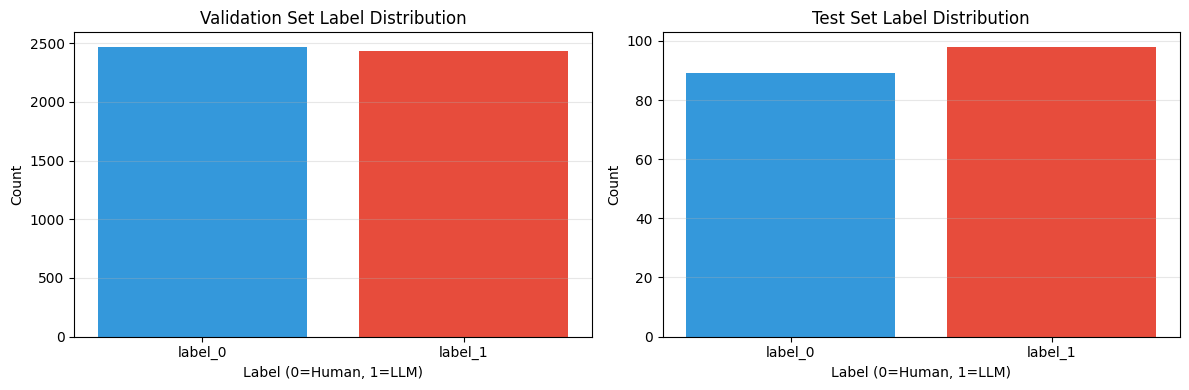

In [32]:
# Visualize label distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Validation set
valid_labels = valid_stats['label_distribution']
axes[0].bar(valid_labels.keys(), valid_labels.values(), color=['#3498db', '#e74c3c'])
axes[0].set_title('Validation Set Label Distribution')
axes[0].set_xlabel('Label (0=Human, 1=LLM)')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# Test set
test_labels = test_stats['label_distribution']
axes[1].bar(test_labels.keys(), test_labels.values(), color=['#3498db', '#e74c3c'])
axes[1].set_title('Test Set Label Distribution')
axes[1].set_xlabel('Label (0=Human, 1=LLM)')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('label_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [33]:
# Examine a sample
sample = valid_dataset[0]
print("\n" + "="*70)
print("SAMPLE DATA POINT")
print("="*70)
print(f"Index: {sample['index']}")
print(f"Label: {sample['label'].item()} ({'Human' if sample['label'].item() == 0 else 'LLM'})")
print(f"\nCode Graph:")
print(f"  Shape: {sample['code_graph'].shape}")
print(f"  Number of nodes: {sample['code_num_nodes']}")
print(f"  Sequence length: {len(sample['code_sequence'])}")
print(f"  First 15 tokens: {sample['code_sequence'][:15]}")
print(f"\nContrast Graph:")
print(f"  Shape: {sample['contrast_graph'].shape}")
print(f"  Number of nodes: {sample['contrast_num_nodes']}")
print(f"  Sequence length: {len(sample['contrast_sequence'])}")
print(f"  First 15 tokens: {sample['contrast_sequence'][:15]}")


SAMPLE DATA POINT
Index: gp266290
Label: 1 (LLM)

Code Graph:
  Shape: torch.Size([500, 500])
  Number of nodes: 13
  Sequence length: 13
  First 15 tokens: [7, 6, 5, 1, 4, 3, 1, 0, 1, 0, 8, 1, 0]

Contrast Graph:
  Shape: torch.Size([500, 500])
  Number of nodes: 60
  Sequence length: 60
  First 15 tokens: [7, 6, 10, 3, 2, 1, 0, 0, 3, 2, 1627, 0, 1, 0, 5]


In [34]:
# Get embedding matrix
embedding_matrix = valid_dataset.get_embedding_matrix()
print(f"\nEmbedding matrix shape: {embedding_matrix.shape}")
print(f"Vocabulary size: {embedding_matrix.shape[0] - 1}")


Embedding matrix shape: torch.Size([3832, 128])
Vocabulary size: 3831


## 3. GIN Model Architecture

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GINLayer(nn.Module):
    """Graph Isomorphism Network Layer.
    
    Implements: h_v^(k) = MLP^(k)((1 + epsilon^(k)) * h_v^(k-1) + sum_{u in N(v)} h_u^(k-1))
    """
    def __init__(self, input_dim, hidden_dim, output_dim, eps_learnable=True):
        super(GINLayer, self).__init__()
        
        # MLP for node update
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU()
        )
        
        # Learnable epsilon parameter
        if eps_learnable:
            self.eps = nn.Parameter(torch.zeros(1))
        else:
            self.register_buffer('eps', torch.zeros(1))
    
    def forward(self, x, adj):
        """
        Args:
            x: Node features [batch_size, num_nodes, feature_dim]
            adj: Adjacency matrix [batch_size, num_nodes, num_nodes]
        
        Returns:
            Updated node features [batch_size, num_nodes, output_dim]
        """
        # Extract dimensions FIRST (critical!)
        batch_size, num_nodes, feature_dim = x.size()
        
        # Aggregate neighbor features: sum_{u in N(v)} h_u
        neighbor_sum = torch.bmm(adj, x)  # [batch_size, num_nodes, feature_dim]
        
        # Remove self-loop from aggregation (we'll add it back with epsilon)
        # Create diagonal mask for each batch
        eye = torch.eye(num_nodes, device=adj.device).unsqueeze(0).expand(batch_size, -1, -1)
        self_features = torch.bmm(eye, x)
        neighbor_sum = neighbor_sum - self_features
        
        # Apply GIN update rule: (1 + eps) * h + sum(neighbors)
        out = (1 + self.eps) * x + neighbor_sum
        
        # Apply MLP
        out = out.view(batch_size * num_nodes, feature_dim)
        out = self.mlp(out)
        out = out.view(batch_size, num_nodes, -1)
        
        return out


class GINNetwork(nn.Module):
    """Graph Isomorphism Network for code classification."""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, 
                 num_classes=2, dropout=0.3, pretrained_embeddings=None):
        super(GINNetwork, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Token embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            # Optionally freeze embeddings
            # self.embedding.weight.requires_grad = False
        
        # GIN layers
        self.gin_layers = nn.ModuleList()
        
        # First layer
        self.gin_layers.append(
            GINLayer(embedding_dim, hidden_dim, hidden_dim, eps_learnable=True)
        )
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.gin_layers.append(
                GINLayer(hidden_dim, hidden_dim, hidden_dim, eps_learnable=True)
            )
        
        # Readout MLP (for graph-level classification)
        self.readout = nn.Sequential(
            nn.Linear(hidden_dim * num_layers, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, sequences, adj_matrices, num_nodes_list):
        """
        Args:
            sequences: LIST of token sequences (Python lists!)
            adj_matrices: Adjacency matrices [batch_size, max_nodes, max_nodes]
            num_nodes_list: List of actual number of nodes
        
        Returns:
            logits: [batch_size, num_classes]
        """
        batch_size = adj_matrices.size(0)
        max_nodes = adj_matrices.size(1)
        
        # FIX: Convert list of sequences to padded tensor, aligned with actual node counts
        node_features = torch.zeros(batch_size, max_nodes, dtype=torch.long, 
                                    device=adj_matrices.device)
        
        for i, seq in enumerate(sequences):
            # Get actual number of nodes for this graph
            num_nodes = num_nodes_list[i]
            # Use min of sequence length and actual nodes to align features with graph structure
            seq_len = min(len(seq), num_nodes)
            # Convert sequence to tensor and pad/truncate to match actual node count
            seq_tensor = torch.tensor(seq[:seq_len], dtype=torch.long, device=adj_matrices.device)
            # Pad with zeros (padding_idx=0) if sequence is shorter than num_nodes
            if seq_len < num_nodes:
                padding = torch.zeros(num_nodes - seq_len, dtype=torch.long, device=adj_matrices.device)
                seq_tensor = torch.cat([seq_tensor, padding])
            node_features[i, :num_nodes] = seq_tensor
        
        # Embed tokens
        x = self.embedding(node_features)
        
        # Apply GIN layers
        layer_outputs = []
        for layer in self.gin_layers:
            x = layer(x, adj_matrices)
            x = F.dropout(x, p=self.dropout, training=self.training)
            layer_outputs.append(x)
        
        # Graph-level readout with masking
        graph_representations = []
        for layer_out in layer_outputs:
            mask = torch.zeros(batch_size, max_nodes, 1, device=layer_out.device)
            for i, num_nodes in enumerate(num_nodes_list):
                mask[i, :num_nodes, :] = 1.0
            
            masked_out = layer_out * mask
            graph_rep = masked_out.sum(dim=1)
            graph_representations.append(graph_rep)
        
        # Concatenate and classify
        graph_rep = torch.cat(graph_representations, dim=1)
        logits = self.readout(graph_rep)
        
        return logits


class SiameseGNN(nn.Module):
    """Siamese network for comparing code and contrast samples."""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers,
                 num_classes=2, dropout=0.3, pretrained_embeddings=None):
        super(SiameseGNN, self).__init__()
        
        # Shared GNN encoder
        self.gnn = GINNetwork(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            num_classes=hidden_dim * num_layers,  # Output embedding instead of class
            dropout=dropout,
            pretrained_embeddings=pretrained_embeddings
        )
        
        # Classifier on combined representations
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * num_layers * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, code_seq, code_adj, code_num_nodes,
                contrast_seq, contrast_adj, contrast_num_nodes):
        """
        Args:
            code_seq: Token sequences for code [batch_size, max_seq_len]
            code_adj: Adjacency matrices for code [batch_size, max_nodes, max_nodes]
            code_num_nodes: Number of nodes for each code graph [batch_size]
            contrast_seq: Token sequences for contrast [batch_size, max_seq_len]
            contrast_adj: Adjacency matrices for contrast [batch_size, max_nodes, max_nodes]
            contrast_num_nodes: Number of nodes for each contrast graph [batch_size]
        
        Returns:
            logits: [batch_size, num_classes]
        """
        # Encode both graphs
        code_embedding = self.gnn(code_seq, code_adj, code_num_nodes)
        contrast_embedding = self.gnn(contrast_seq, contrast_adj, contrast_num_nodes)
        
        # Concatenate embeddings
        combined = torch.cat([code_embedding, contrast_embedding], dim=1)
        
        # Classify
        logits = self.classifier(combined)
        
        return logits


print("GIN Model Architecture defined successfully!")

GIN Model Architecture defined successfully!


## 4. Training Setup

In [36]:
def collate_code_batch(batch):
    """Custom collate function to handle variable-length sequences."""
    indices = [item['index'] for item in batch]
    labels = torch.stack([item['label'] for item in batch])
    code_graphs = torch.stack([item['code_graph'] for item in batch])
    contrast_graphs = torch.stack([item['contrast_graph'] for item in batch])
    code_num_nodes = [item['code_num_nodes'] for item in batch]
    contrast_num_nodes = [item['contrast_num_nodes'] for item in batch]
    code_sequences = [item['code_sequence'] for item in batch]
    contrast_sequences = [item['contrast_sequence'] for item in batch]
    
    return {
        'index': indices,
        'label': labels,
        'code_graph': code_graphs,
        'contrast_graph': contrast_graphs,
        'code_num_nodes': code_num_nodes,
        'contrast_num_nodes': contrast_num_nodes,
        'code_sequence': code_sequences,
        'contrast_sequence': contrast_sequences
    }

# Create data loaders WITH CUSTOM COLLATE FUNCTION
train_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_code_batch  # ← KEY FIX
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_code_batch  # ← KEY FIX
)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 77
Test batches: 3


In [37]:
# Initialize model
vocab_size = embedding_matrix.shape[0]

model = SiameseGNN(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_SIZE,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    num_classes=2,
    dropout=0.3,
    pretrained_embeddings=embedding_matrix
).to(device)

print(f"\nModel initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Model initialized with 2,433,799 parameters
Trainable parameters: 2,433,799


In [38]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, verbose=True
)

print("Training setup complete!")

Training setup complete!


/Users/nishka/miniconda3/envs/cs224w/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 5. Training Loop

In [39]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(loader, desc='Training', leave=False)
    
    for batch in progress_bar:
        # Move data to device
        code_graph = batch['code_graph'].to(device)
        contrast_graph = batch['contrast_graph'].to(device)
        labels = batch['label'].to(device)
        
        code_num_nodes = batch['code_num_nodes']
        contrast_num_nodes = batch['contrast_num_nodes']
        
        code_seq = batch['code_sequence']
        contrast_seq = batch['contrast_sequence']
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(
            code_seq, code_graph, code_num_nodes,
            contrast_seq, contrast_graph, contrast_num_nodes
        )
        
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    """Evaluate model on validation/test set."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating', leave=False):
            # Move data to device
            code_graph = batch['code_graph'].to(device)
            contrast_graph = batch['contrast_graph'].to(device)
            labels = batch['label'].to(device)
            
            code_num_nodes = batch['code_num_nodes']
            contrast_num_nodes = batch['contrast_num_nodes']
            
            code_seq = batch['code_sequence']
            contrast_seq = batch['contrast_sequence']
            
            # Forward pass
            logits = model(
                code_seq, code_graph, code_num_nodes,
                contrast_seq, contrast_graph, contrast_num_nodes
            )
            
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            # Get predictions and probabilities
            probs = F.softmax(logits, dim=1)
            _, predicted = torch.max(logits, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', zero_division=0
    )
    
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = 0.0
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy * 100,
        'precision': precision * 100,
        'recall': recall * 100,
        'f1': f1 * 100,
        'auc': auc,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }


print("Training functions defined!")

Training functions defined!


In [ ]:
# Training loop
train_losses = []
train_accs = []
test_losses = []
test_accs = []
test_f1s = []

best_test_f1 = 0
best_model_state = None

print("Starting training...\n")

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 70)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate
    test_metrics = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_metrics['loss'])
    test_accs.append(test_metrics['accuracy'])
    test_f1s.append(test_metrics['f1'])
    
    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss:  {test_metrics['loss']:.4f} | Test Acc:  {test_metrics['accuracy']:.2f}%")
    print(f"Test Precision: {test_metrics['precision']:.2f}% | Test Recall: {test_metrics['recall']:.2f}%")
    print(f"Test F1: {test_metrics['f1']:.2f}% | Test AUC: {test_metrics['auc']:.4f}")
    
    # Learning rate scheduling
    scheduler.step(test_metrics['f1'])
    
    # Save best model
    if test_metrics['f1'] > best_test_f1:
        best_test_f1 = test_metrics['f1']
        best_model_state = model.state_dict().copy()
        print(f"*** New best F1: {best_test_f1:.2f}% ***")
    
    print()

print(f"\nTraining complete! Best test F1: {best_test_f1:.2f}%")

# Load best model
model.load_state_dict(best_model_state)
torch.save(best_model_state, 'best_model.pth')
print("Best model saved to 'best_model.pth'")

Starting training...

Epoch 1/30
----------------------------------------------------------------------


Train Loss: 2.0237 | Train Acc: 78.12%
Test Loss:  0.3423 | Test Acc:  89.30%
Test Precision: 91.49% | Test Recall: 87.76%
Test F1: 89.58% | Test AUC: 0.9531
*** New best F1: 89.58% ***

Epoch 2/30
----------------------------------------------------------------------


Train Loss: 0.4010 | Train Acc: 85.33%
Test Loss:  0.3449 | Test Acc:  89.84%
Test Precision: 91.58% | Test Recall: 88.78%
Test F1: 90.16% | Test AUC: 0.9587
*** New best F1: 90.16% ***

Epoch 3/30
----------------------------------------------------------------------


Train Loss: 0.3496 | Train Acc: 86.43%
Test Loss:  0.2224 | Test Acc:  93.05%
Test Precision: 92.93% | Test Recall: 93.88%
Test F1: 93.40% | Test AUC: 0.9758
*** New best F1: 93.40% ***

Epoch 4/30
----------------------------------------------------------------------


Train Loss: 0.3004 | Train Acc: 87.92%
Test Loss:  0.2678 | Test Acc:  90.37%
Test Precision: 96.51% | Test Recall: 84.69%
Test F1: 90.22% | Test AUC: 0.9651

Epoch 5/30
----------------------------------------------------------------------


Train Loss: 0.2961 | Train Acc: 88.37%
Test Loss:  0.2563 | Test Acc:  91.44%
Test Precision: 95.56% | Test Recall: 87.76%
Test F1: 91.49% | Test AUC: 0.9750

Epoch 6/30
----------------------------------------------------------------------


Train Loss: 0.3047 | Train Acc: 89.45%
Test Loss:  0.1857 | Test Acc:  93.05%
Test Precision: 92.93% | Test Recall: 93.88%
Test F1: 93.40% | Test AUC: 0.9812

Epoch 7/30
----------------------------------------------------------------------


Train Loss: 0.3152 | Train Acc: 88.49%
Test Loss:  0.2412 | Test Acc:  93.05%
Test Precision: 90.48% | Test Recall: 96.94%
Test F1: 93.60% | Test AUC: 0.9745
*** New best F1: 93.60% ***

Epoch 8/30
----------------------------------------------------------------------


Train Loss: 0.2525 | Train Acc: 89.98%
Test Loss:  0.1605 | Test Acc:  94.12%
Test Precision: 95.79% | Test Recall: 92.86%
Test F1: 94.30% | Test AUC: 0.9875
*** New best F1: 94.30% ***

Epoch 9/30
----------------------------------------------------------------------


Train Loss: 0.2515 | Train Acc: 89.79%
Test Loss:  0.2220 | Test Acc:  93.58%
Test Precision: 94.79% | Test Recall: 92.86%
Test F1: 93.81% | Test AUC: 0.9811

Epoch 10/30
----------------------------------------------------------------------


Train Loss: 0.2426 | Train Acc: 90.10%
Test Loss:  0.2241 | Test Acc:  93.05%
Test Precision: 93.81% | Test Recall: 92.86%
Test F1: 93.33% | Test AUC: 0.9797

Epoch 11/30
----------------------------------------------------------------------


Train Loss: 0.2597 | Train Acc: 90.65%
Test Loss:  0.1935 | Test Acc:  91.44%
Test Precision: 96.59% | Test Recall: 86.73%
Test F1: 91.40% | Test AUC: 0.9849

Epoch 12/30
----------------------------------------------------------------------


Train Loss: 0.2207 | Train Acc: 90.79%
Test Loss:  0.2069 | Test Acc:  92.51%
Test Precision: 88.89% | Test Recall: 97.96%
Test F1: 93.20% | Test AUC: 0.9804

Epoch 13/30
----------------------------------------------------------------------


Train Loss: 0.2756 | Train Acc: 90.93%
Test Loss:  0.2024 | Test Acc:  92.51%
Test Precision: 93.75% | Test Recall: 91.84%
Test F1: 92.78% | Test AUC: 0.9819

Epoch 14/30
----------------------------------------------------------------------


Train Loss: 0.2114 | Train Acc: 91.61%
Test Loss:  0.2511 | Test Acc:  91.44%
Test Precision: 94.57% | Test Recall: 88.78%
Test F1: 91.58% | Test AUC: 0.9735

Epoch 15/30
----------------------------------------------------------------------


Train Loss: 0.2054 | Train Acc: 92.32%
Test Loss:  0.2197 | Test Acc:  91.98%
Test Precision: 94.62% | Test Recall: 89.80%
Test F1: 92.15% | Test AUC: 0.9805

Epoch 16/30
----------------------------------------------------------------------


Train Loss: 0.1835 | Train Acc: 92.32%
Test Loss:  0.1715 | Test Acc:  93.05%
Test Precision: 92.93% | Test Recall: 93.88%
Test F1: 93.40% | Test AUC: 0.9860

Epoch 17/30
----------------------------------------------------------------------


Train Loss: 0.1943 | Train Acc: 91.99%
Test Loss:  0.1695 | Test Acc:  94.65%
Test Precision: 94.90% | Test Recall: 94.90%
Test F1: 94.90% | Test AUC: 0.9870
*** New best F1: 94.90% ***

Epoch 18/30
----------------------------------------------------------------------


Train Loss: 0.1817 | Train Acc: 92.36%
Test Loss:  0.2761 | Test Acc:  94.12%
Test Precision: 94.85% | Test Recall: 93.88%
Test F1: 94.36% | Test AUC: 0.9764

Epoch 19/30
----------------------------------------------------------------------


Train Loss: 0.1719 | Train Acc: 92.83%
Test Loss:  0.2317 | Test Acc:  94.65%
Test Precision: 94.90% | Test Recall: 94.90%
Test F1: 94.90% | Test AUC: 0.9814

Epoch 20/30
----------------------------------------------------------------------


Train Loss: 0.1834 | Train Acc: 92.50%
Test Loss:  0.1682 | Test Acc:  93.58%
Test Precision: 93.88% | Test Recall: 93.88%
Test F1: 93.88% | Test AUC: 0.9845

Epoch 21/30
----------------------------------------------------------------------


Train Loss: 0.1725 | Train Acc: 92.89%
Test Loss:  0.1411 | Test Acc:  95.19%
Test Precision: 95.88% | Test Recall: 94.90%
Test F1: 95.38% | Test AUC: 0.9907
*** New best F1: 95.38% ***

Epoch 22/30
----------------------------------------------------------------------


Train Loss: 0.1716 | Train Acc: 92.52%
Test Loss:  0.1976 | Test Acc:  93.58%
Test Precision: 93.88% | Test Recall: 93.88%
Test F1: 93.88% | Test AUC: 0.9830

Epoch 23/30
----------------------------------------------------------------------


Train Loss: 0.1594 | Train Acc: 93.48%
Test Loss:  0.2538 | Test Acc:  93.05%
Test Precision: 93.81% | Test Recall: 92.86%
Test F1: 93.33% | Test AUC: 0.9825

Epoch 24/30
----------------------------------------------------------------------


Training:  57%|█████▋    | 44/77 [01:01<00:45,  1.37s/it, loss=0.1716, acc=93.50%]

## 6. Results Visualization

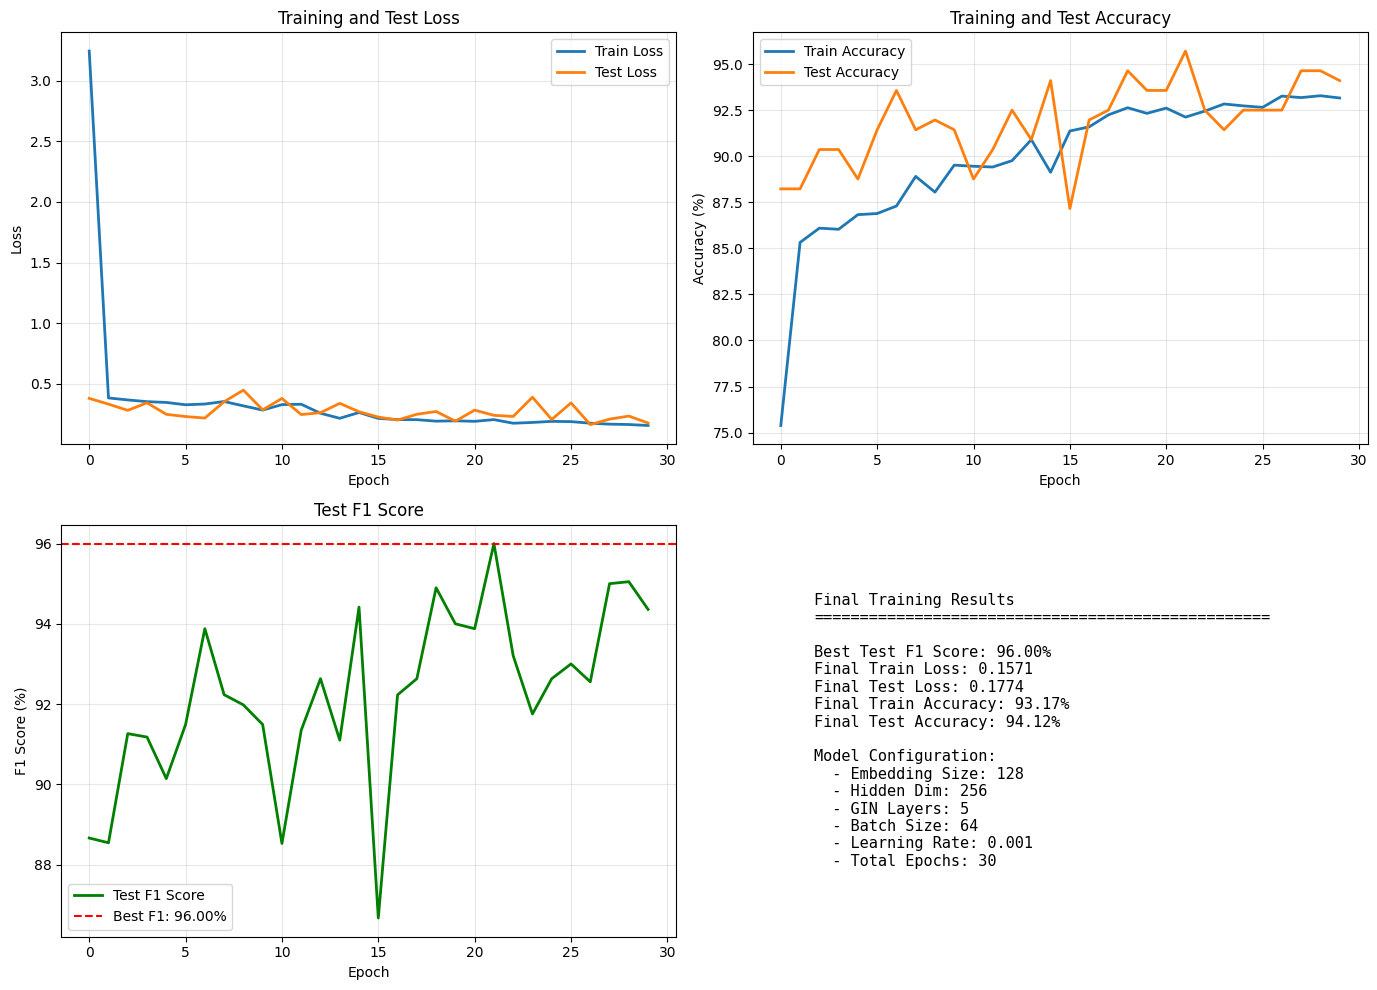

In [16]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curves
axes[0, 0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0, 0].plot(test_losses, label='Test Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Test Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy curves
axes[0, 1].plot(train_accs, label='Train Accuracy', linewidth=2)
axes[0, 1].plot(test_accs, label='Test Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Test Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# F1 curve
axes[1, 0].plot(test_f1s, label='Test F1 Score', linewidth=2, color='green')
axes[1, 0].axhline(y=best_test_f1, color='r', linestyle='--', label=f'Best F1: {best_test_f1:.2f}%')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score (%)')
axes[1, 0].set_title('Test F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Summary statistics
axes[1, 1].axis('off')
summary_text = f"""
Final Training Results
{'='*50}

Best Test F1 Score: {best_test_f1:.2f}%
Final Train Loss: {train_losses[-1]:.4f}
Final Test Loss: {test_losses[-1]:.4f}
Final Train Accuracy: {train_accs[-1]:.2f}%
Final Test Accuracy: {test_accs[-1]:.2f}%

Model Configuration:
  - Embedding Size: {EMBEDDING_SIZE}
  - Hidden Dim: {HIDDEN_DIM}
  - GIN Layers: {NUM_LAYERS}
  - Batch Size: {BATCH_SIZE}
  - Learning Rate: {LEARNING_RATE}
  - Total Epochs: {NUM_EPOCHS}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Final Evaluation on Test Set

In [17]:
# Final evaluation with best model
print("Evaluating best model on test set...\n")
final_metrics = evaluate(model, test_loader, criterion, device)

print("="*70)
print("FINAL TEST SET RESULTS")
print("="*70)
print(f"Accuracy:  {final_metrics['accuracy']:.2f}%")
print(f"Precision: {final_metrics['precision']:.2f}%")
print(f"Recall:    {final_metrics['recall']:.2f}%")
print(f"F1 Score:  {final_metrics['f1']:.2f}%")
print(f"AUC-ROC:   {final_metrics['auc']:.4f}")
print("="*70)

Evaluating best model on test set...



FINAL TEST SET RESULTS
Accuracy:  94.12%
Precision: 94.85%
Recall:    93.88%
F1 Score:  94.36%
AUC-ROC:   0.9854


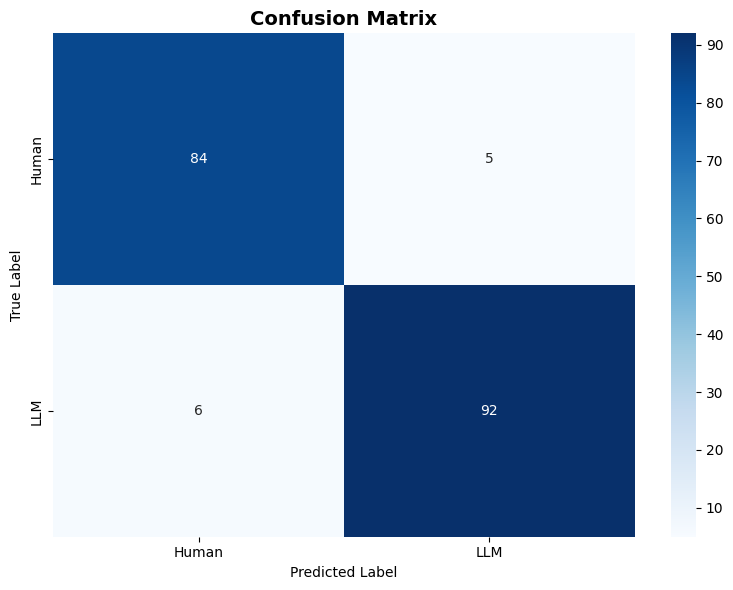


Confusion Matrix:
[[84  5]
 [ 6 92]]


In [18]:
# Confusion matrix
cm = confusion_matrix(final_metrics['labels'], final_metrics['predictions'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Human', 'LLM'],
            yticklabels=['Human', 'LLM'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConfusion Matrix:")
print(cm)

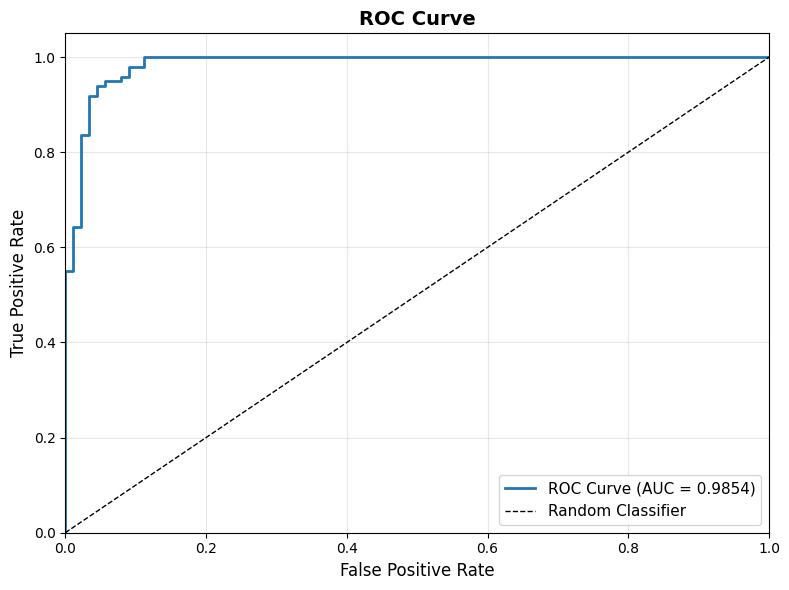

In [19]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(final_metrics['labels'], final_metrics['probabilities'])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {final_metrics["auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Error Analysis

In [20]:
# Analyze misclassifications
predictions = np.array(final_metrics['predictions'])
labels = np.array(final_metrics['labels'])
probabilities = np.array(final_metrics['probabilities'])

# Find misclassified samples
misclassified_idx = np.where(predictions != labels)[0]
correct_idx = np.where(predictions == labels)[0]

print(f"Total samples: {len(labels)}")
print(f"Correctly classified: {len(correct_idx)} ({100*len(correct_idx)/len(labels):.2f}%)")
print(f"Misclassified: {len(misclassified_idx)} ({100*len(misclassified_idx)/len(labels):.2f}%)")

# Breakdown by class
human_misclassified = np.where((predictions != labels) & (labels == 0))[0]
llm_misclassified = np.where((predictions != labels) & (labels == 1))[0]

print(f"\nMisclassified breakdown:")
print(f"  Human → LLM: {len(human_misclassified)} (false positives)")
print(f"  LLM → Human: {len(llm_misclassified)} (false negatives)")

Total samples: 187
Correctly classified: 176 (94.12%)
Misclassified: 11 (5.88%)

Misclassified breakdown:
  Human → LLM: 5 (false positives)
  LLM → Human: 6 (false negatives)


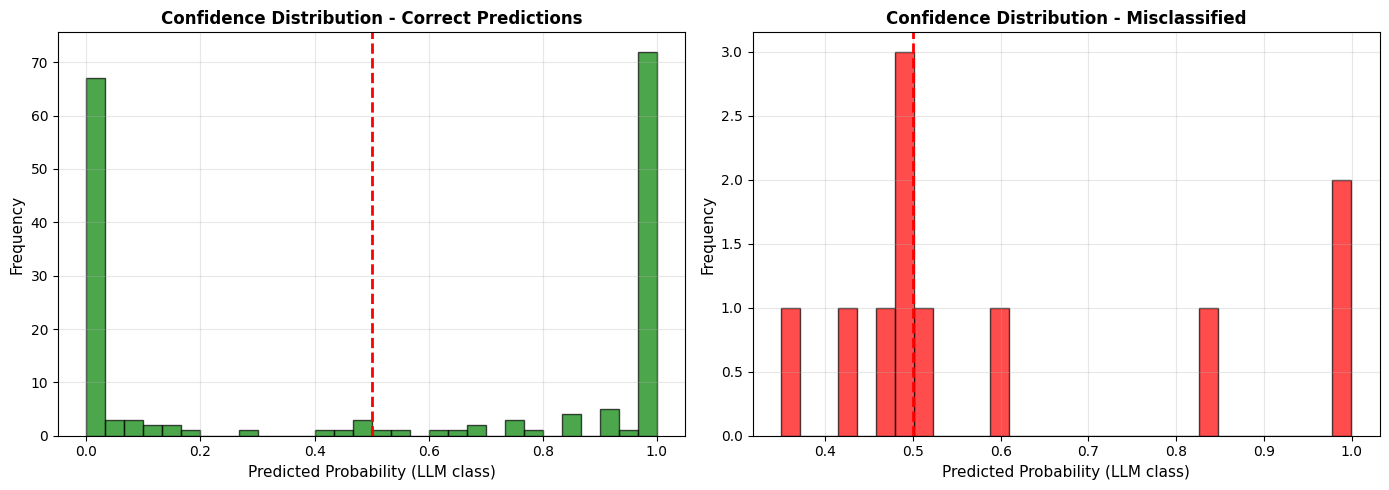

In [21]:
# Confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence for correct predictions
correct_probs = probabilities[correct_idx]
axes[0].hist(correct_probs, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0].axvline(x=0.5, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Probability (LLM class)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Confidence Distribution - Correct Predictions', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Confidence for misclassified predictions
misclassified_probs = probabilities[misclassified_idx]
axes[1].hist(misclassified_probs, bins=30, alpha=0.7, color='red', edgecolor='black')
axes[1].axvline(x=0.5, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Probability (LLM class)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Confidence Distribution - Misclassified', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Model Saving and Summary

In [22]:
# Save complete model checkpoint
checkpoint = {
    'model_state_dict': best_model_state,
    'vocab_size': vocab_size,
    'embedding_dim': EMBEDDING_SIZE,
    'hidden_dim': HIDDEN_DIM,
    'num_layers': NUM_LAYERS,
    'max_nodes': MAX_NODES,
    'best_test_f1': best_test_f1,
    'final_metrics': final_metrics,
    'train_losses': train_losses,
    'test_losses': test_losses,
    'train_accs': train_accs,
    'test_accs': test_accs,
    'test_f1s': test_f1s
}

torch.save(checkpoint, 'checkpoint.pth')
print("Complete checkpoint saved to 'checkpoint.pth'")

Complete checkpoint saved to 'checkpoint.pth'


In [23]:
# Save results summary
results_summary = {
    'model_config': {
        'embedding_size': EMBEDDING_SIZE,
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS,
        'max_nodes': MAX_NODES,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS
    },
    'final_metrics': {
        'accuracy': float(final_metrics['accuracy']),
        'precision': float(final_metrics['precision']),
        'recall': float(final_metrics['recall']),
        'f1': float(final_metrics['f1']),
        'auc': float(final_metrics['auc'])
    },
    'confusion_matrix': cm.tolist(),
    'dataset_stats': {
        'train_size': len(valid_dataset),
        'test_size': len(test_dataset),
        'vocab_size': vocab_size
    }
}

with open('results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Results summary saved to 'results_summary.json'")

Results summary saved to 'results_summary.json'


## 10. Sample Predictions

In [24]:
# Show some example predictions
num_examples = 5

print("\n" + "="*70)
print("SAMPLE PREDICTIONS")
print("="*70)

for i in range(min(num_examples, len(test_dataset))):
    sample = test_dataset[i]
    
    # Prepare inputs
    code_graph = sample['code_graph'].unsqueeze(0).to(device)
    contrast_graph = sample['contrast_graph'].unsqueeze(0).to(device)
    code_seq = [sample['code_sequence']]
    contrast_seq = [sample['contrast_sequence']]
    code_num_nodes = [sample['code_num_nodes']]
    contrast_num_nodes = [sample['contrast_num_nodes']]
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        logits = model(code_seq, code_graph, code_num_nodes,
                      contrast_seq, contrast_graph, contrast_num_nodes)
        probs = F.softmax(logits, dim=1)
        pred = torch.argmax(logits, dim=1).item()
        confidence = probs[0][pred].item()
    
    true_label = sample['label'].item()
    
    print(f"\nSample {i+1}:")
    print(f"  Index: {sample['index']}")
    print(f"  True Label: {true_label} ({'Human' if true_label == 0 else 'LLM'})")
    print(f"  Predicted: {pred} ({'Human' if pred == 0 else 'LLM'})")
    print(f"  Confidence: {confidence*100:.2f}%")
    print(f"  Code nodes: {sample['code_num_nodes']}, Contrast nodes: {sample['contrast_num_nodes']}")
    print(f"  {'✓ CORRECT' if pred == true_label else '✗ INCORRECT'}")


SAMPLE PREDICTIONS

Sample 1:
  Index: gp093776
  True Label: 0 (Human)
  Predicted: 0 (Human)
  Confidence: 99.13%
  Code nodes: 25, Contrast nodes: 9
  ✓ CORRECT

Sample 2:
  Index: gp029077
  True Label: 0 (Human)
  Predicted: 1 (LLM)
  Confidence: 50.58%
  Code nodes: 41, Contrast nodes: 12
  ✗ INCORRECT

Sample 3:
  Index: gp035028
  True Label: 0 (Human)
  Predicted: 0 (Human)
  Confidence: 98.94%
  Code nodes: 42, Contrast nodes: 13
  ✓ CORRECT

Sample 4:
  Index: gp209243
  True Label: 1 (LLM)
  Predicted: 1 (LLM)
  Confidence: 100.00%
  Code nodes: 108, Contrast nodes: 103
  ✓ CORRECT

Sample 5:
  Index: gp235921
  True Label: 1 (LLM)
  Predicted: 1 (LLM)
  Confidence: 100.00%
  Code nodes: 20, Contrast nodes: 41
  ✓ CORRECT
